<a href="https://colab.research.google.com/github/Hyunseo-BA/BigData_Lab/blob/master/rnn_time_series_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## The weather dataset
Max Planck 연구소의 날씨 데이터 셋.
* 온도, 기압, 습도 등의14 개의 feature
* 2003년 부터 매 10 분마다 측정 된 데이터 셋
* 우리가 다루는 데이터는 2009년 ~ 2016년 사이에 측정된 데이터
* 10분마다 한번씩 측정된 데이터 이기 때문에 하루에는 144 (6x24) 개의 시퀀스가 존재

In [ ]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13574144/13568290 [==============================] - 1s 0us/step


In [ ]:
df = pd.read_csv(csv_path)

In [ ]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [ ]:
def univariate_data(dataset, start_index,
                    end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

* 300,000 번째 row(~2,100 day) 를 기준으로 학습데이터 셋과 테스트 데이터 셋 분할

In [ ]:
TRAIN_SPLIT = 300000

In [ ]:
tf.random.set_seed(13)

In [ ]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f966f145518>],
      dtype=object)

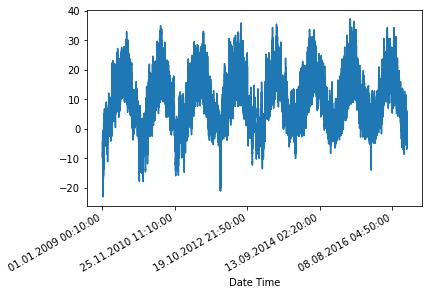

In [ ]:
uni_data.plot(subplots=True)

In [ ]:
uni_data = uni_data.values

In [ ]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [ ]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

* 20 시퀀스의 데이터 를 입력하여 10분 후의 온도를 예측하는 모델 구현을 위한 데이터 생성

In [ ]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [ ]:
print(x_train_uni.shape)
print(y_train_uni.shape)
print(x_val_uni.shape)
print(y_val_uni.shape)

(299980, 20, 1)
(299980,)
(120531, 20, 1)
(120531,)


In [ ]:
def create_time_steps(length):
  return list(range(-length, 0))

In [ ]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

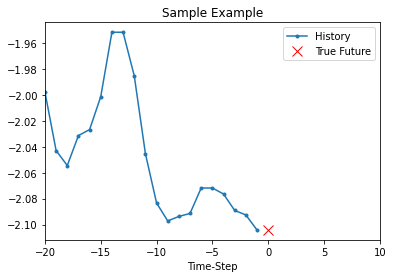

In [ ]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

### Baseline
* 시계열 데이터의 올바른 성능 측정을 위한 base line 생성

In [ ]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

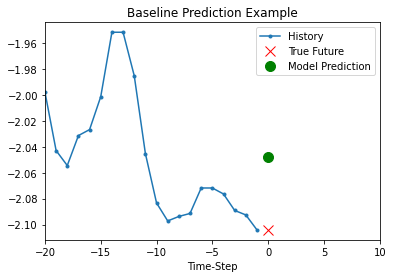

In [ ]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

In [ ]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

#### RNN 모델을 이용한 시계열 데이터 예측

In [ ]:
simple_rnn_model = tf.keras.models.Sequential(
    [tf.keras.layers.SimpleRNN(8, input_shape=x_train_uni.shape[-2:]),
     tf.keras.layers.Dense(1)])

simple_rnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
for x, y in val_univariate.take(1):
    print(simple_rnn_model.predict(x).shape)

(256, 1)


In [ ]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_rnn_model.fit(train_univariate, epochs=EPOCHS,
                     steps_per_epoch=EVALUATION_INTERVAL,
                     validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 3s 15ms/step - loss: 0.4341 - mae: 0.4318 - val_loss: 0.0321 - val_mae: 0.1328
Epoch 2/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0479 - mae: 0.1292 - val_loss: 0.0138 - val_mae: 0.0715
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0195 - mae: 0.0915 - val_loss: 0.0088 - val_mae: 0.0584
Epoch 4/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0233 - mae: 0.0891 - val_loss: 0.0074 - val_mae: 0.0569
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0074 - mae: 0.0546 - val_loss: 0.0051 - val_mae: 0.0404
Epoch 6/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0085 - mae: 0.0586 - val_loss: 0.0031 - val_mae: 0.0345
Epoch 7/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0066 - mae: 0.0460 - val_loss: 0.0030 - val_mae: 0.0339
Epoch 8/10
200/200 [==============================] - 3s 14ms/step - 

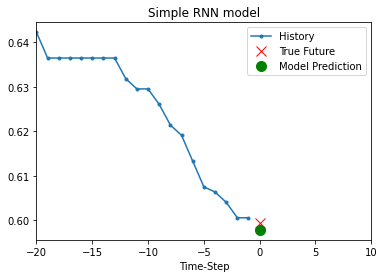

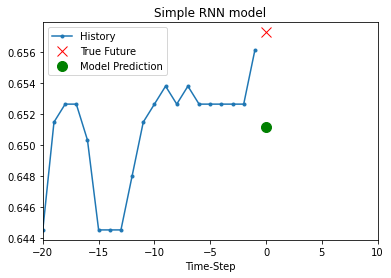

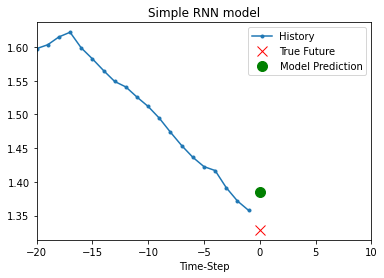

In [ ]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_rnn_model.predict(x)[0]], 0, 'Simple RNN model')
  plot.show()

#### LSTM 모델을 이용한 시계열 데이터 예측

In [ ]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [ ]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 1s 6ms/step - loss: 0.6144 - mae: 0.5687 - val_loss: 0.0489 - val_mae: 0.1847
Epoch 2/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0905 - mae: 0.1894 - val_loss: 0.0063 - val_mae: 0.0577
Epoch 3/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0151 - mae: 0.0766 - val_loss: 0.0037 - val_mae: 0.0411
Epoch 4/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0169 - mae: 0.0676 - val_loss: 0.0024 - val_mae: 0.0336
Epoch 5/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0051 - mae: 0.0416 - val_loss: 0.0019 - val_mae: 0.0295
Epoch 6/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0053 - mae: 0.0426 - val_loss: 0.0017 - val_mae: 0.0282
Epoch 7/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0043 - mae: 0.0392 - val_loss: 0.0016 - val_mae: 0.0275
Epoch 8/10
200/200 [==============================] - 1s 4ms/step - loss: 0.

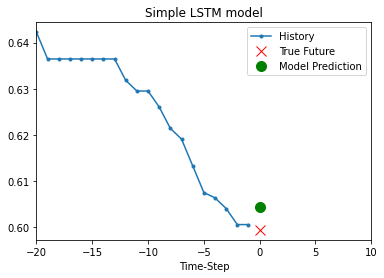

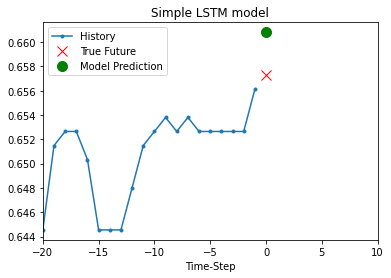

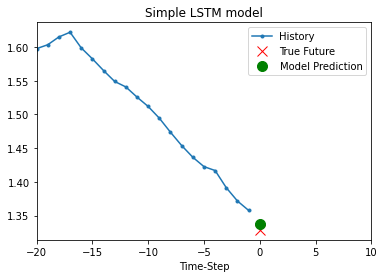

In [ ]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

#### 적층 LSTM 모델을 이용한 시계열 데이터 예측

In [ ]:
stacked_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:],
                         return_sequences=True),
    tf.keras.layers.LSTM(8),
    tf.keras.layers.Dense(1)
])

stacked_lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

stacked_lstm_model.fit(train_univariate, epochs=EPOCHS,
                       steps_per_epoch=EVALUATION_INTERVAL,
                       validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 2s 9ms/step - loss: 0.1507 - mae: 0.2535 - val_loss: 0.0164 - val_mae: 0.0989
Epoch 2/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0251 - mae: 0.1034 - val_loss: 0.0069 - val_mae: 0.0625
Epoch 3/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0110 - mae: 0.0735 - val_loss: 0.0044 - val_mae: 0.0460
Epoch 4/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0089 - mae: 0.0625 - val_loss: 0.0033 - val_mae: 0.0398
Epoch 5/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0049 - mae: 0.0459 - val_loss: 0.0029 - val_mae: 0.0368
Epoch 6/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0051 - mae: 0.0480 - val_loss: 0.0027 - val_mae: 0.0364
Epoch 7/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0043 - mae: 0.0433 - val_loss: 0.0024 - val_mae: 0.0339
Epoch 8/10
200/200 [==============================] - 1s 6ms/step - loss: 0.

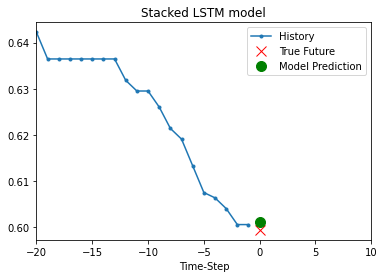

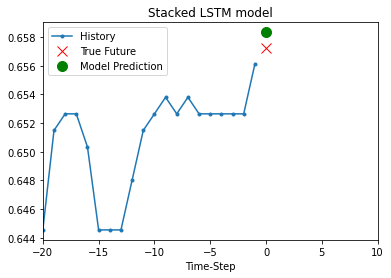

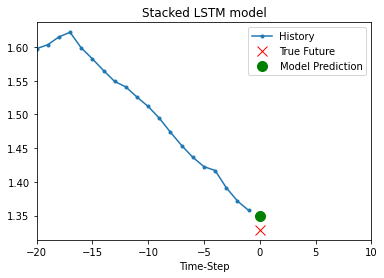

In [ ]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    stacked_lstm_model.predict(x)[0]], 0, 'Stacked LSTM model')
  plot.show()